Reading rx power tensor so we can calculate SNR. 

In [ ]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor[rx_power_tensor==0] = -np.infty
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts


#print(np.sum((rx_power_tensor==0.0)))
#print(10**(-0.1*np.infty))

print(np.min(rx_power_tensor))

Calculating SNR. Non-existent paths have been assigned -250 dB SNR which is very low.

In [2]:
BW = 400e6 #bandwidth
k = 1.38e-23 #boltzmann's constant
NF = 10**(0.9) #noise figue 
T = 298 #temperature

NoisePower = k*BW*NF*T


SNRs = rx_power_tensor/NoisePower

SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25))) # total number of non exisitent paths


54582


Reading all other characteristics and adding noise


In [3]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aoa_tensor = azimuth_aoa_tensor + azimuth_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aod_tensor = azimuth_aod_tensor + azimuth_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aod_tensor = zenith_aod_tensor + zenith_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

# mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
# rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
# rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
# rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms
toa_tensor = toa_tensor + toa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


In [4]:
print(azimuth_aoa_tensor.shape)

(150000, 4, 25)


**Constructing the input tensor with dimensions n_samples x n_bs x n_paths x n_features**

In [5]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


Each input sample has a shape 600x1

In [6]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep dense neural network (DDNN) approach**
Constructing DDNN and declaring all hyper-parameters. We tried batchnorm and dropout. It resulted in worse performance

In [7]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0)  ## assuming we know the minimum coordinates, done for stability of relu
true_cord_tensor = true_cord_tensor



model = models.Sequential()
model.add(layers.Dense(400, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(300,activation = 'relu'))
model.add(layers.Dense(200,activation = 'relu'))
model.add(layers.Dense(300,activation = 'relu'))
model.add(layers.Dense(200,activation = 'relu'))
model.add(layers.Dense(100,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               240400    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3

Training split. Preprocessing data.


In [8]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler() # pre processing data
scaled_df = scaler.fit(X_train) 
scaled_df = scaler.transform(X_train)

Running training. 

In [9]:
model.fit(scaled_df, y_train, epochs=500, batch_size=32, verbose = 2)

Epoch 1/500
2344/2344 - 9s - loss: 7641.8843
Epoch 2/500
2344/2344 - 9s - loss: 1321.4891
Epoch 3/500
2344/2344 - 9s - loss: 800.2351
Epoch 4/500
2344/2344 - 9s - loss: 607.1538
Epoch 5/500
2344/2344 - 11s - loss: 475.5820
Epoch 6/500
2344/2344 - 10s - loss: 370.5728
Epoch 7/500
2344/2344 - 12s - loss: 287.4359
Epoch 8/500
2344/2344 - 11s - loss: 232.1598
Epoch 9/500
2344/2344 - 10s - loss: 192.5002
Epoch 10/500
2344/2344 - 10s - loss: 164.4725
Epoch 11/500
2344/2344 - 10s - loss: 142.1530
Epoch 12/500
2344/2344 - 11s - loss: 121.0538
Epoch 13/500
2344/2344 - 12s - loss: 108.9601
Epoch 14/500
2344/2344 - 9s - loss: 100.2818
Epoch 15/500
2344/2344 - 9s - loss: 86.6721
Epoch 16/500
2344/2344 - 9s - loss: 80.3028
Epoch 17/500
2344/2344 - 9s - loss: 76.5888
Epoch 18/500
2344/2344 - 9s - loss: 69.5404
Epoch 19/500
2344/2344 - 9s - loss: 65.1876
Epoch 20/500
2344/2344 - 9s - loss: 62.6920
Epoch 21/500
2344/2344 - 9s - loss: 63.7038
Epoch 22/500
2344/2344 - 8s - loss: 49.5134
Epoch 23/500
234

2344/2344 - 8s - loss: 2.5675
Epoch 186/500
2344/2344 - 9s - loss: 15.0585
Epoch 187/500
2344/2344 - 8s - loss: 5.2842
Epoch 188/500
2344/2344 - 8s - loss: 2.4275
Epoch 189/500
2344/2344 - 8s - loss: 2.0118
Epoch 190/500
2344/2344 - 8s - loss: 2.7610
Epoch 191/500
2344/2344 - 8s - loss: 2.4373
Epoch 192/500
2344/2344 - 8s - loss: 2.6333
Epoch 193/500
2344/2344 - 6s - loss: 2.5611
Epoch 194/500
2344/2344 - 7s - loss: 2.7960
Epoch 195/500
2344/2344 - 8s - loss: 6.8458
Epoch 196/500
2344/2344 - 8s - loss: 1.9094
Epoch 197/500
2344/2344 - 10s - loss: 2.0876
Epoch 198/500
2344/2344 - 8s - loss: 2.3325
Epoch 199/500
2344/2344 - 9s - loss: 2.7652
Epoch 200/500
2344/2344 - 10s - loss: 7.1578
Epoch 201/500
2344/2344 - 11s - loss: 1.8902
Epoch 202/500
2344/2344 - 10s - loss: 2.1927
Epoch 203/500
2344/2344 - 9s - loss: 2.3205
Epoch 204/500
2344/2344 - 9s - loss: 3.8314
Epoch 205/500
2344/2344 - 9s - loss: 2.4608
Epoch 206/500
2344/2344 - 9s - loss: 2.1199
Epoch 207/500
2344/2344 - 9s - loss: 2.93

Epoch 371/500
2344/2344 - 9s - loss: 1.0853
Epoch 372/500
2344/2344 - 8s - loss: 1.1704
Epoch 373/500
2344/2344 - 8s - loss: 1.1141
Epoch 374/500
2344/2344 - 9s - loss: 1.1742
Epoch 375/500
2344/2344 - 10s - loss: 6.8408
Epoch 376/500
2344/2344 - 10s - loss: 0.8016
Epoch 377/500
2344/2344 - 10s - loss: 0.7767
Epoch 378/500
2344/2344 - 9s - loss: 1.0211
Epoch 379/500
2344/2344 - 9s - loss: 1.1126
Epoch 380/500
2344/2344 - 10s - loss: 1.2330
Epoch 381/500
2344/2344 - 8s - loss: 1.1214
Epoch 382/500
2344/2344 - 9s - loss: 3.4723
Epoch 383/500
2344/2344 - 9s - loss: 3.1214
Epoch 384/500
2344/2344 - 10s - loss: 1.1313
Epoch 385/500
2344/2344 - 6s - loss: 0.6964
Epoch 386/500
2344/2344 - 7s - loss: 0.9242
Epoch 387/500
2344/2344 - 10s - loss: 1.1155
Epoch 388/500
2344/2344 - 9s - loss: 1.0989
Epoch 389/500
2344/2344 - 9s - loss: 1.0413
Epoch 390/500
2344/2344 - 7s - loss: 1.1218
Epoch 391/500
2344/2344 - 6s - loss: 1.0646
Epoch 392/500
2344/2344 - 7s - loss: 1.0813
Epoch 393/500
2344/2344 - 

Predicting on all data. 

In [10]:
pred_vals = model.predict(scaler.transform(input_tensor)) 

pred_train = model.predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In case we need to calculate errors in training, testing, overall. 

In [11]:
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

Calculating error norms. 

In [12]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


Constructing CDFs. 

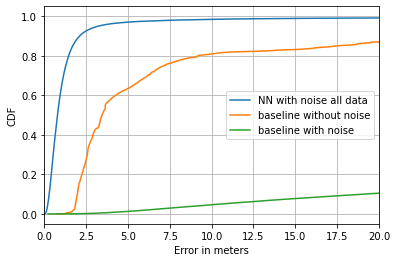

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)


mat = scipy.io.loadmat('erorwithnoise.mat')
err_data = mat['eroraray']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN with noise all data','baseline without noise','baseline with noise'])


Mean error

In [14]:
print(np.mean(norm_error))

2.46637086609196


80% CDF intersection point  

In [15]:
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

The 80% percentile error in meters is  1.4594818387233912